# Catastrophe bond Price Prediction Model

## 1. Data Collection and Preprocessing
### 1.1 Importing Libraries

In [3]:
# Install necessary libraries in Colab
!pip install ta

# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import yfinance as yf  # For downloading stock data
import ta  # For technical analysis indicators
from sklearn.preprocessing import RobustScaler  # For scaling features
from sklearn.model_selection import TimeSeriesSplit  # For time series cross-validation
from sklearn.ensemble import GradientBoostingRegressor  # Gradient Boosting model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error  # For model evaluation
from sklearn.feature_selection import SelectFromModel  # For feature selection
from sklearn.pipeline import Pipeline  # For creating a model pipeline
from sklearn.base import BaseEstimator, TransformerMixin  # For custom transformers
from sklearn.impute import SimpleImputer  # For handling missing values
from sklearn.feature_selection import RFECV, mutual_info_regression
from xgboost import XGBRegressor  # XGBoost model
from lightgbm import LGBMRegressor  # LightGBM model
from keras.models import Sequential  # For building neural networks
from keras.layers import LSTM, Dense, Dropout  # Layers for LSTM model
from keras.optimizers import Adam  # Adam optimizer for neural networks
import optuna  # For hyperparameter optimization
from statsmodels.tsa.statespace.sarimax import SARIMAX  # For SARIMA modeling
from prophet import Prophet  # Facebook's Prophet model for time series forecasting
import matplotlib.pyplot as plt  # For plotting
import shap  # For model interpretability
from textblob import TextBlob  # For sentiment analysis
import requests  # For making HTTP requests
import json
from scipy.stats import spearmanr
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # For Holt-Winters' exponential smoothing
from pmdarima import auto_arima  # For automatic ARIMA modeling
from sklearn.linear_model import ElasticNet  # Elastic Net regression
from sklearn.ensemble import VotingRegressor  # For ensemble modeling
from datetime import datetime, timedelta  # For date and time operations
import pytz  # For timezone handling
import torch  # PyTorch for deep learning
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, TensorDataset  # For data loading
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig  # For time series transformers
import gym  # For reinforcement learning environments
from stable_baselines3 import PPO  # Proximal Policy Optimization algorithm
from stable_baselines3.common.vec_env import DummyVecEnv  # For vectorized environments
import warnings  # For handling warnings
from sklearn.feature_selection import RFECV  # Recursive Feature Elimination with Cross-Validation
from sklearn.linear_model import LassoCV  # Lasso regression with built-in cross-validation

warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def get_enhanced_targets(df):
    """
    Create multiple target variables for enhanced prediction accuracy.
    """
    # Create risk-adjusted spread
    df['risk_adjusted_spread'] = df['spread_bps'] * (1 + df['insurance_risk'])
    
    # Calculate probability of attachment using expected loss and insurance risk
    df['probability_of_attachment'] = df['expected_loss'] * (1 - np.exp(-df['insurance_risk']))
    
    # Calculate conditional expected loss
    df['conditional_expected_loss'] = df['expected_loss'] / df['probability_of_attachment'].clip(lower=0.01)
    
    # Calculate market relative value
    df['market_relative_value'] = df['spread_bps'] / df['expected_loss'].clip(lower=0.01)
    
    return {
        'expected_loss': df['expected_loss'],
        'risk_adjusted_spread': df['risk_adjusted_spread'],
        'probability_of_attachment': df['probability_of_attachment'],
        'conditional_expected_loss': df['conditional_expected_loss'],
        'market_relative_value': df['market_relative_value']
    }

### 1.2 Fetching Bitcoin Data

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime

def get_enhanced_targets(df):
    """
    Create multiple target variables for enhanced prediction accuracy based on available columns.
    First prints available columns and then creates appropriate target variables.
    """
    print("Available columns in dataset:", df.columns.tolist())
    
    targets = {}
    
    # Base target - expected loss
    if 'expected_loss' in df.columns:
        targets['expected_loss'] = df['expected_loss']
        
        # Log-transformed expected loss
        targets['log_expected_loss'] = np.log1p(df['expected_loss'].clip(lower=0.0001))
        
        # Risk levels (1-5)
        targets['risk_level'] = pd.qcut(df['expected_loss'], q=5, labels=[1,2,3,4,5]).astype(float)
    
    # Insurance risk based targets
    if 'insurance_risk' in df.columns:
        targets['insurance_risk'] = df['insurance_risk']
        
        if 'expected_loss' in df.columns:
            targets['risk_adjusted_loss'] = df['expected_loss'] * (1 + df['insurance_risk'])
    
    # First loss probability based targets
    if 'probability_first_loss' in df.columns:
        targets['probability_first_loss'] = df['probability_first_loss']
        
        if 'expected_loss' in df.columns:
            # Conditional loss given first loss
            targets['conditional_loss'] = df['expected_loss'] / df['probability_first_loss'].clip(lower=0.0001)
    
    # ROLX based targets
    if 'rolx' in df.columns:
        targets['rolx'] = df['rolx']
        
        if 'expected_loss' in df.columns:
            targets['risk_premium'] = df['rolx'] * df['expected_loss']
    
    # Create additional derived targets if needed
    if len(targets) < 3:
        print("Warning: Creating additional derived targets from available data.")
        
        base_target = list(targets.values())[0]
        base_name = list(targets.keys())[0]
        
        # Rolling statistics
        rolling_window = min(10, len(df) // 5)
        targets[f'{base_name}_ma'] = base_target.rolling(window=rolling_window, min_periods=1).mean()
        targets[f'{base_name}_volatility'] = base_target.rolling(window=rolling_window, min_periods=1).std()
        targets[f'{base_name}_roc'] = base_target.pct_change().fillna(0)
    
    if len(targets) < 2:
        raise ValueError("Insufficient data for multi-target prediction. Need at least 2 targets.")
    
    print("\nCreated target variables:", list(targets.keys()))
    
    # Clean up any infinite or null values
    for key in targets:
        targets[key] = targets[key].replace([np.inf, -np.inf], np.nan)
        targets[key] = targets[key].fillna(targets[key].median())
    
    return targets

def get_training_data(csv_file_path, target_name='expected_loss', test_size=0.2, random_state=42):
    """
    Load and preprocess the training data for a specific target variable.
    
    Parameters:
    -----------
    csv_file_path : str
        Path to the CSV file containing the data
    target_name : str
        Name of the target variable to use (must be one of the enhanced targets)
    test_size : float
        Proportion of the dataset to include in the test split
    random_state : int
        Random state for reproducibility
        
    Returns:
    --------
    dict : Dictionary containing X_train, X_test, y_train, y_test for the specified target
    """
    # Load the CSV data
    print(f"Loading data from {csv_file_path}")
    df = pd.read_csv(csv_file_path)
    
    # Generate enhanced targets
    targets = get_enhanced_targets(df)
    
    if target_name not in targets:
        raise ValueError(f"Target '{target_name}' not found in available targets: {list(targets.keys())}")
    
    # Drop the target columns and Date from features
    all_target_columns = list(targets.keys())
    feature_columns = [col for col in df.columns if col not in all_target_columns + ['Date']]
    
    if not feature_columns:
        raise ValueError("No feature columns remaining after removing targets.")
    
    print("\nUsing feature columns:", feature_columns)
    X = df[feature_columns]
    y = targets[target_name]
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y,
        test_size=test_size,
        random_state=random_state
    )
    
    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_columns': feature_columns,
        'scaler': scaler
    }
# Example usage
if __name__ == "__main__":
    csv_file_path = 'alphaized_data.csv'
    
    # Get training data for expected loss prediction
    train_data = get_training_data(csv_file_path, target_name='expected_loss')
    
    # Access the split data
    X_train = train_data['X_train']
    X_test = train_data['X_test']
    y_train = train_data['y_train']
    y_test = train_data['y_test']
    
    # Display shapes
    print("\nData shapes:")
    print("Training Features:", X_train.shape)
    print("Test Features:", X_test.shape)
    print("Training Target:", y_train.shape)
    print("Test Target:", y_test.shape)
    
    # Get training data for a different target if needed
    risk_data = get_training_data(csv_file_path, target_name='risk_level')

Loading data from alphaized_data.csv
Available columns in dataset: ['Date', 'collat_yield', 'insurance_risk', 'expected_loss', 'Temperature', 'Precipitation']

Created target variables: ['expected_loss', 'log_expected_loss', 'risk_level', 'insurance_risk', 'risk_adjusted_loss']

Using feature columns: ['collat_yield', 'Temperature', 'Precipitation']

Data shapes:
Training Features: (222, 3)
Test Features: (56, 3)
Training Target: (222,)
Test Target: (56,)
Loading data from alphaized_data.csv
Available columns in dataset: ['Date', 'collat_yield', 'insurance_risk', 'expected_loss', 'Temperature', 'Precipitation']

Created target variables: ['expected_loss', 'log_expected_loss', 'risk_level', 'insurance_risk', 'risk_adjusted_loss']

Using feature columns: ['collat_yield', 'Temperature', 'Precipitation']


## 2. Feature Engineering

In [8]:

# Custom transformer for Recursive Feature Elimination with Cross-Validation
class RFECVTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that performs feature selection using SelectFromModel.

    This transformer is designed to work with scikit-learn's pipeline and
    cross-validation tools.
    """
    def __init__(self, estimator, step=1, cv=5):

        self.estimator = estimator
        self.step = step
        self.cv = cv
        self.selector = SelectFromModel(estimator=estimator, threshold='median')

    def fit(self, X, y=None):

        self.selector.fit(X, y)
        return self

    def transform(self, X):

        return self.selector.transform(X)

# Function to calculate double exponential moving average


### 2.2 Technical Indicators and Custom Features

In [10]:
def engineer_features(self):
    """Enhanced feature engineering based on available columns"""
    df = self.data.copy()

    # Basic transformations and risk metrics
    df['el_squared'] = df['expected_loss'] ** 2
    df['insurance_risk_squared'] = df['insurance_risk'] ** 2

    # Market cycle interactions
    df['el_market'] = df['expected_loss'] * df['insurance_risk']

    # Risk premium calculations
    df['risk_premium'] = df['spread_bps'] - df['expected_loss_bps']
    df['risk_premium_ratio'] = df['risk_premium'] / df['expected_loss_bps']

    # Market condition indicators using collat_yield as a proxy for market stress
    df['market_stress'] = df['insurance_risk'] * df['collat_yield']

    # Climate risk interaction
    df['climate_risk'] = (df['Temperature'] * df['Precipitation']) / \
                         (df['Temperature'].mean() * df['Precipitation'].mean())

    # Time-based features
    if 'Date' in df.columns:
        df['month'] = df['Date'].dt.month
        df['year'] = df['Date'].dt.year
        df['quarter'] = df['Date'].dt.quarter

    # Probability of First Loss (PFL) already exists
    if 'probability_first_loss' in df.columns:
        df['pfl'] = df['probability_first_loss']

    # ROLX already exists in the dataset
    if 'rolx' in df.columns:
        df['rolx_feature'] = df['rolx']  # Example renaming for clarity

    # Handle any infinity or NA values that might have been created
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.mean())

    return df

## 3. Feature Selection
### 3.1 Advanced Feature Selection

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

def advanced_feature_selection(X, y, n_splits=5, verbose=True):
    """
    Performing advanced feature selection using multiple methods.

    """
    # Initialize TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Define a custom scoring function that combines MSE and Spearman correlation
    def custom_score(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        corr, _ = spearmanr(y_true, y_pred)
        return -mse * (1 + corr) / 2

    custom_scorer = make_scorer(custom_score, greater_is_better=True)

    # Recursive Feature Elimination with Cross-Validation (RFECV) using XGBoost
    xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
    rfecv = RFECV(estimator=xgb_model, step=1, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, min_features_to_select=1)
    rfecv.fit(X, y)
    rfecv_features = X.columns[rfecv.support_].tolist()

    # LASSO feature selection
    lasso = LassoCV(cv=tscv, random_state=42, n_jobs=-1)
    lasso.fit(X, y)

    lasso_features = X.columns[np.abs(lasso.coef_) > np.percentile(np.abs(lasso.coef_), 75)].tolist()

    # Random Forest feature importance
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X, y)

    importance_threshold = np.percentile(rf_model.feature_importances_, 75)
    rf_features = X.columns[rf_model.feature_importances_ > importance_threshold].tolist()

    # Mutual Information feature selection
    mi_scores = mutual_info_regression(X, y)

    mi_threshold = np.percentile(mi_scores, 75)
    mi_features = X.columns[mi_scores > mi_threshold].tolist()

    # Combine all selected features
    selected_features = list(set(rfecv_features) | set(lasso_features) | set(rf_features) | set(mi_features))

    if verbose:
        print(f"RFECV selected {len(rfecv_features)} features")
        print(f"LASSO selected {len(lasso_features)} features")
        print(f"Random Forest selected {len(rf_features)} features")
        print(f"Mutual Information selected {len(mi_features)} features")
        print(f"Combined selection: {len(selected_features)} features")


        feature_importance = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
        print("\nTop 10 features by Random Forest importance:")
        for importance, feature in feature_importance[:10]:
            print(f"{feature}: {importance:.4f}")


    if len(selected_features) < 5:
        print("Too few features selected. Using top 10 features by Random Forest importance.")
        return [feature for _, feature in feature_importance[:10]]

    return selected_features

In [13]:
class MultiTargetPredictor:
    def __init__(self, models_dict):
        self.models = models_dict
        self.trained_models = {}
        self.scalers = {}
    
    def fit(self, splits):
        """Train models for each target variable"""
        for target_name, split_data in splits.items():
            print(f"\nTraining models for {target_name}...")
            
            # Scale target variable
            scaler = StandardScaler()
            y_train_scaled = scaler.fit_transform(split_data['y_train'].values.reshape(-1, 1)).ravel()
            
            # Store scaler for prediction
            self.scalers[target_name] = scaler
            
            # Train models for this target
            self.trained_models[target_name] = {}
            for model_name, model in self.models.items():
                print(f"Training {model_name}...")
                model_copy = clone(model)
                model_copy.fit(split_data['X_train'], y_train_scaled)
                self.trained_models[target_name][model_name] = model_copy
    
    def predict(self, X_test):
        """Make predictions for each target variable"""
        predictions = {}
        
        for target_name, models in self.trained_models.items():
            target_predictions = {}
            
            for model_name, model in models.items():
                # Make prediction and inverse transform
                pred_scaled = model.predict(X_test)
                pred = self.scalers[target_name].inverse_transform(pred_scaled.reshape(-1, 1)).ravel()
                target_predictions[model_name] = pred
            
            # Average predictions from different models for this target
            predictions[target_name] = np.mean(list(target_predictions.values()), axis=0)
        
        return predictions

## 4. Model Development
### 4.1 LSTM Model
### 4.2 Transformer Model

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

# Download the dataset
start_date = '2010-01-01'
end_date = '2020-01-01'
df = yf.download("BTC-USD", start=start_date, end=end_date)

# Feature Engineering
def engineer_features(df):
    # Example: Calculating 7-day Return on Investment (ROI) for price data
    df['7d_ROI'] = df['Adj Close'].pct_change(periods=7)
    df['7d_ROI'] = df['7d_ROI'].shift(-7)  # Adjust for future price
    return df

df = engineer_features(df)

# Data Cleaning
df = df.dropna()

# Selecting numeric features only
df = df.select_dtypes(include=[np.number])

# Clean the target variable (remove outliers)
def clean_target_variable(y):
    y = y.replace([np.inf, -np.inf], np.nan).dropna()
    mean = y.mean()
    std = y.std()
    y = y[(y > mean - 5*std) & (y < mean + 5*std)]
    return y

# Clean the target and align X with the cleaned y
y_cleaned = clean_target_variable(df['7d_ROI'])
X_cleaned = df.drop('7d_ROI', axis=1).loc[y_cleaned.index]  # Align X with the cleaned target

# Re-assign the cleaned X and y
X = X_cleaned
y = y_cleaned

# Train-test split
train_size = int(len(X) * 0.8)
split_date = X.index[train_size]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM (3D format)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# LSTM Model Definition
def create_lstm_model(input_shape, dropout_rate=0.5, neurons=[512, 256, 128]):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(neurons[0], input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers
    for units in neurons[1:-1]:
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(dropout_rate))

    # Final LSTM layer
    model.add(LSTM(neurons[-1]))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Create and train the LSTM model
lstm_model = create_lstm_model(input_shape=X_train.shape[1:])
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
lstm_model.evaluate(X_test, y_test)

# Optional: Transformer Model (if you'd like to test it as well)
def create_transformer_model(input_shape):
    config = TimeSeriesTransformerConfig(
        d_model=64,
        n_heads=4,
        n_layers=4,
        dim_feedforward=256,
        dropout=0.1,
        activation="gelu",
        context_length=input_shape[0],
        prediction_length=1
    )
    model = TimeSeriesTransformerModel(config)
    return model


[*********************100%%**********************]  1 of 1 completed

Epoch 1/10


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0140 - val_loss: 0.0094
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127 - val_loss: 0.0094
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0120 - val_loss: 0.0094
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - val_loss: 0.0094
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - val_loss: 0.0095
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - val_loss: 0.0094
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - val_loss: 0.0096
Epoch 9/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 10/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - val_loss: 0.0094
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090


In [16]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.knn_imputer = KNNImputer(n_neighbors=5)
        self.median_imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        self.cont_features = X.select_dtypes(include=['float64', 'int64']).columns
        self.other_features = X.columns.difference(self.cont_features)
        if not self.cont_features.empty:
            self.knn_imputer.fit(X[self.cont_features])
        if not self.other_features.empty:
            self.median_imputer.fit(X[self.other_features])

        return self

    def transform(self, X):
        X_transformed = X.copy()
        if not self.cont_features.empty:
            X_cont = pd.DataFrame(
                self.knn_imputer.transform(X[self.cont_features]),
                columns=self.cont_features,
                index=X.index
            )
            X_transformed[self.cont_features] = X_cont
        if not self.other_features.empty:
            X_other = pd.DataFrame(
                self.median_imputer.transform(X[self.other_features]),
                columns=self.other_features,
                index=X.index
            )
            X_transformed[self.other_features] = X_other

        return X_transformed

# Objective function for hyperparameter optimization
def objective(trial, X, y, cv, preprocessor):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10)
    }

    model = XGBRegressor(**params, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)
        model.fit(X_train_processed, y_train)
        pred = model.predict(X_val_processed)
        score = mean_squared_error(y_val, pred)
        scores.append(score)
    return np.mean(scores)

In [17]:
class ExtremeValueHandler(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        for column in X.columns:
            # mean and standard deviation for the column
            mean = X[column].mean()
            std = X[column].std()

            # Cliping values outside the range [mean - threshold * std, mean + threshold * std]
            X_transformed[column] = X[column].clip(
                lower=mean - self.threshold * std,
                upper=mean + self.threshold * std
            )

        return X_transformed

## Hyperparameter Optimization

In [19]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
import optuna

# Custom transformer to handle extreme values
class ExtremeValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.columns:
            if X_copy[column].dtype in ['int64', 'float64']:
                # Calculating IQR and bounds
                Q1 = X_copy[column].quantile(0.25)
                Q3 = X_copy[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.threshold * IQR
                upper_bound = Q3 + self.threshold * IQR
                # Clip values to the bounds
                X_copy[column] = X_copy[column].clip(lower_bound, upper_bound)
        return X_copy

# Custom transformer to filter highly correlated features
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold

    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        self.corr_matrix = X.corr().abs()
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        upper = self.corr_matrix.where(np.triu(np.ones(self.corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return X.drop(columns=to_drop)

# Wrapper to ensure transformers return DataFrames
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        result = self.transformer.transform(X)
        if isinstance(result, np.ndarray):
            return pd.DataFrame(result, columns=X.columns, index=X.index)
        return result

def create_pipeline(trial):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns

    # Numeric data preprocessing
    numeric_transformer = Pipeline([
        ('extreme_value_handler', ExtremeValueHandler(threshold=trial.suggest_float('evh_threshold', 2, 4))),
        ('imputer', KNNImputer(n_neighbors=trial.suggest_int('knn_neighbors', 3, 7))),
        ('scaler', RobustScaler()),
        ('qt', QuantileTransformer(n_quantiles=trial.suggest_int('qt_quantiles', 100, 1000), output_distribution='normal')),
    ])

    # Categorical data preprocessing
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

    # Combining numeric and categorical preprocessors
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

    preprocessor = DataFrameWrapper(preprocessor)

    # Feature selection pipeline
    feature_selector = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=trial.suggest_float('vt_threshold', 0.005, 0.02))),
        ('correlation_filter', CorrelationFilter(threshold=trial.suggest_float('corr_threshold', 0.9, 0.99))),
        ('univariate_selection', SelectKBest(score_func=f_regression, k=trial.suggest_int('k_best', 5, len(X.columns)))),  # Fixing the range
        ('pca', PCA(n_components=trial.suggest_float('pca_components', 0.8, 0.99))),
    ])

    # XGBoost model with hyperparameters
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        subsample=trial.suggest_uniform('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        random_state=42
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('model', model),
    ])

    return pipeline

# Objective function for Optuna
def objective(trial):
    pipeline = create_pipeline(trial)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean()

def optimize_pipeline(X, y, n_trials=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    best_pipeline = create_pipeline(study.best_trial)
    best_pipeline.fit(X, y)

    return best_pipeline, study.best_trial

# Assuming df is already defined
X = df.drop('7d_ROI', axis=1)


### Preprocessing Pipeline

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Example function for feature selection (replace with your actual implementation)
def advanced_feature_selection(X, y):
    # Example feature selection logic (replace with your actual feature selection)
    selected_features = X.columns  # For now, return all features as selected
    return selected_features

# Custom transformer to handle extreme values
class ExtremeValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, replace_inf=True, replace_large=True, large_threshold=1e300):
        self.replace_inf = replace_inf
        self.replace_large = replace_large
        self.large_threshold = large_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if self.replace_inf:
            X = X.replace([np.inf, -np.inf], np.nan)

        if self.replace_large:
            X = X.mask(X.abs() > self.large_threshold, np.nan)

        return X

# Sample dataset (replace with actual data)
data = pd.DataFrame({
    'feature_1': np.random.rand(1925),
    'feature_2': np.random.rand(1925),
    'feature_3': np.random.rand(1925),
    'feature_4': np.random.rand(1925),
    'feature_5': np.random.rand(1925),
    'feature_6': np.random.rand(1925)
})
target = pd.Series(np.random.randint(0, 2, size=1924))  # Target with one less row

# Print initial shapes and any NaN values
print(f"Shape of X before preprocessing: {data.shape}")
print(f"Shape of y before preprocessing: {target.shape}")
print(f"Any NaN values in X before feature selection: {data.isna().any().any()}")
print(f"Any NaN values in y before feature selection: {target.isna().any()}")

# Feature selection
selected_features = advanced_feature_selection(data, target)

# Apply feature selection
X = data[selected_features]
y = target

# Check if there's a mismatch between the number of rows in X and y before preprocessing
if X.shape[0] != y.shape[0]:
    print(f"Mismatch before processing: X has {X.shape[0]} rows, y has {y.shape[0]} rows")
    
    # Here, let's remove the last row from X (or y) to align them
    if X.shape[0] > y.shape[0]:
        X = X[:-1]  # Remove the last row from X to match y's length
    elif y.shape[0] > X.shape[0]:
        y = y[:-1]  # Remove the last row from y to match X's length

# Ensure no mismatch between X and y
assert X.shape[0] == y.shape[0], "Mismatch between X and y after fixing"

# Print the updated shapes
print(f"Shape of X after feature selection: {X.shape}")
print(f"Shape of y after feature selection: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes after train-test split
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Define preprocessing pipeline
preprocessor = Pipeline([
    ('extreme_value_handler', ExtremeValueHandler()),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Apply preprocessing steps
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Print results after preprocessing
print(f"Shape of X_train after processing: {X_train.shape}")
print(f"Shape of X_test after processing: {X_test.shape}")
print(f"Any infinity values in X_train: {np.isinf(X_train).any().any()}")
print(f"Any infinity values in X_test: {np.isinf(X_test).any().any()}")
print(f"Any NaN values in X_train: {np.isnan(X_train).any().any()}")
print(f"Any NaN values in X_test: {np.isnan(X_test).any().any()}")

Shape of X before preprocessing: (1925, 6)
Shape of y before preprocessing: (1924,)
Any NaN values in X before feature selection: False
Any NaN values in y before feature selection: False
Mismatch before processing: X has 1925 rows, y has 1924 rows
Shape of X after feature selection: (1924, 6)
Shape of y after feature selection: (1924,)
Shape of X_train: (1539, 6)
Shape of X_test: (385, 6)
Shape of y_train: (1539,)
Shape of y_test: (385,)
Shape of X_train after processing: (1539, 6)
Shape of X_test after processing: (385, 6)
Any infinity values in X_train: False
Any infinity values in X_test: False
Any NaN values in X_train: False
Any NaN values in X_test: False


In [22]:
def optunaobjective(trial, X, y, cv, preprocessor):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10)
    }

    model = XGBRegressor(**params, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)

        model.fit(X_train_processed, y_train)
        pred = model.predict(X_val_processed)

        score = mean_squared_error(y_val, pred)
        scores.append(score)

    return np.mean(scores)

cv = TimeSeriesSplit(n_splits=5)

study = optuna.create_study(direction='minimize')

study.optimize(lambda trial: optunaobjective(trial, X, y, cv, preprocessor), n_trials=500)

best_params = study.best_params

[I 2024-11-16 08:07:59,459] A new study created in memory with name: no-name-31fbe6f2-4443-43af-8b58-c73dedd3e081
[I 2024-11-16 08:08:00,201] Trial 0 finished with value: 0.25727642519143873 and parameters: {'n_estimators': 137, 'max_depth': 8, 'learning_rate': 0.010488363675490338, 'subsample': 0.8820259502389374, 'subsample_freq': 7}. Best is trial 0 with value: 0.25727642519143873.
[I 2024-11-16 08:08:04,776] Trial 1 finished with value: 0.28409178555127995 and parameters: {'n_estimators': 608, 'max_depth': 10, 'learning_rate': 0.02114173022133457, 'subsample': 0.7338927467906388, 'subsample_freq': 4}. Best is trial 0 with value: 0.25727642519143873.
[I 2024-11-16 08:08:05,297] Trial 2 finished with value: 0.4446072278036858 and parameters: {'n_estimators': 760, 'max_depth': 5, 'learning_rate': 0.9411743190090524, 'subsample': 0.9638309555809326, 'subsample_freq': 7}. Best is trial 0 with value: 0.25727642519143873.
[I 2024-11-16 08:08:06,743] Trial 3 finished with value: 0.26361169

### 4.3 Tree-based Models (GBR, XGBoost, LightGBM)

In [24]:
# Gradient Boosting Regressor
gb_best = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],
                                    max_depth=best_params['max_depth'],
                                    learning_rate=best_params['learning_rate'],
                                    subsample=best_params['subsample'],
                                    random_state=42)

# XGBoost Regressor
# Using **best_params to pass all optimized parameters at once
xgb_best = XGBRegressor(**best_params, random_state=42)

# LightGBM Regressor
# using **best_params for consistency with XGBoost
lgb_best = LGBMRegressor(**best_params, random_state=42)

# Note: These models are initialized with optimized hyperparameters.
# The 'best_params' dictionary is assumed to be obtained from a previous optimization process.
# All models use random_state=42 for reproducibility.

### 4.4 Linear Models (Elastic Net)

In [26]:
# Elastic Net for L1 and L2 regularization
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

In [27]:
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

train_size = int(len(X) * 0.8)
split_date = X.index[train_size]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:split_date], y[split_date:]

train_index = X_train.index
test_index = X_test.index

original_feature_names = X_train.columns.tolist()

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

if X_train.shape[1] != len(original_feature_names):
    processed_feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
else:
    processed_feature_names = original_feature_names

X_train = pd.DataFrame(X_train, index=train_index, columns=processed_feature_names)
X_test = pd.DataFrame(X_test, index=test_index, columns=processed_feature_names)

selected_features = processed_feature_names

y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

original_index = X_train.index
sample_weights = np.linspace(0.5, 1, len(X_train))

In [28]:
train_size = int(len(X) * 0.8)
split_date = X.index[train_size]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y.loc[:split_date], y.loc[split_date:]

X_train_df = X_train.copy()
y_train_df = y_train.copy()

sample_weights_series = pd.Series(sample_weights, index=X_train.index)

aligned_index = X_train_df.index.intersection(y_train_df.index).intersection(sample_weights_series.index)
X_train_df = X_train_df.loc[aligned_index]
y_train_df = y_train_df.loc[aligned_index]
sample_weights_series = sample_weights_series.loc[aligned_index]

# Converting back to numpy arrays
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
sample_weights = sample_weights_series.to_numpy()

# Converting to float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
sample_weights = sample_weights.astype(np.float32)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("sample_weights shape:", sample_weights.shape)
print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("NaN in sample_weights:", np.isnan(sample_weights).sum())


print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of sample_weights: {len(sample_weights)}")

X_train shape: (1539, 6)
y_train shape: (1539,)
sample_weights shape: (1539,)
NaN in X_train: 0
NaN in y_train: 0
NaN in sample_weights: 0
Length of X_train: 1539
Length of y_train: 1539
Length of sample_weights: 1539


In [29]:
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.to_numpy()

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Creating and training the LSTM model
lstm_model = create_lstm_model((1, X_train.shape[1]), dropout_rate=0.5, neurons=[512, 256, 128])

lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

lstm_pred = lstm_model.predict(X_test_lstm).flatten()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


### 4.5 Time Series Models (SARIMA, Exponential Smoothing, Prophet)

In [31]:
# SARIMA model creation and prediction

# Using auto_arima to automatically find the best SARIMA parameters
# seasonal=True: Enable seasonal component
# m=7: Set the seasonal period to 7
auto_arima_model = auto_arima(y_train, seasonal=True, m=7)

sarima_order = auto_arima_model.order
sarima_seasonal_order = auto_arima_model.seasonal_order

sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=sarima_seasonal_order)

sarima_results = sarima_model.fit()

sarima_pred = sarima_results.forecast(steps=len(X_test))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40044D-01    |proj g|=  1.07469D-03

At iterate    5    f=  9.40044D-01    |proj g|=  4.17122D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   4.171D-07   9.400D-01
  F =  0.94004432410514049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [32]:
# Exponential Smoothing model creation and prediction

# trend='add': Use an additive trend component
# seasonal='add': Use an additive seasonal component
exp_smoothing = ExponentialSmoothing(y_train, seasonal_periods=7, trend='add', seasonal='add')

exp_smoothing_results = exp_smoothing.fit()

exp_smoothing_pred = exp_smoothing_results.forecast(len(X_test))

## Ensemble Creation
### Voting Regressor Setup

In [34]:
# Creating an ensemble model using VotingRegressor
ensemble = VotingRegressor([
    ('gb', gb_best),
    ('xgb', xgb_best),
    ('lgb', lgb_best),
    ('elastic_net', elastic_net)
], weights=[2, 2, 2, 1])  # Assigning weights to each model

ensemble.fit(X_train, y_train, sample_weight=sample_weights)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1539, number of used features: 6
[LightGBM] [Info] Start training from score 0.499202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(learning_rate=0.002348934099808753,
                                                       max_depth=4,
                                                       n_estimators=234,
                                                       random_state=42,
                                                       subsample=0.9807320211310001)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_ca...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=234,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('lgb',
                             LGBMRegressor(learning_rate=0.002348934099808753,
                                           max_depth=4, n_estimators=234,
                                           random_state=42,
                                           subsample=0.9807320211310001,
                                           subsample_freq=6)),
                            ('elastic_net',
                             ElasticNet(alpha=0.1, random_state=42))],
                weights=[2, 2, 2, 1])

## 5. Model Training and Prediction
### 5.1 Data Preparation and Splitting
### 5.2 Model Fitting
### 5.3 Model Prediction

In [36]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

# Prepare data
X = df.drop('7d_ROI', axis=1)
y = df['7d_ROI']

# Performing feature selection
selected_features = advanced_feature_selection(X, y)
X = X[selected_features]

# First split the data without sample weights
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Calculate sample weights based on training data
sample_weights = np.ones(len(X_train))  # Using uniform weights
# Or use this if you want balanced weights:
# sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Print shapes to verify alignment
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("sample_weights shape:", sample_weights.shape)

# Gradient Boosting
gb_best.fit(X_train, y_train, sample_weight=sample_weights)

# XGBoost
xgb_best.fit(X_train, y_train, sample_weight=sample_weights)

# LightGBM
lgb_best.fit(X_train, y_train, sample_weight=sample_weights)

# Elastic Net
elastic_net.fit(X_train, y_train, sample_weight=sample_weights)

# Making predictions using each model
gb_pred = gb_best.predict(X_test)
xgb_pred = xgb_best.predict(X_test)
lgb_pred = lgb_best.predict(X_test)
elastic_net_pred = elastic_net.predict(X_test)

# LSTM prediction
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# SARIMA prediction
sarima_pred = sarima_results.forecast(steps=len(X_test))

# Exponential Smoothing prediction
exp_smoothing_pred = exp_smoothing_results.forecast(len(X_test))

# Ensemble prediction
ensemble_pred = ensemble.predict(X_test)

X_train shape: (1540, 6)
y_train shape: (1540,)
sample_weights shape: (1540,)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 6
[LightGBM] [Info] Start training from score 0.017236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

## 6. Model Retraining and Final Prediction
### 6.1 Updating Dataset
### 6.2 Model Retraining
### 6.3 Generating Final Predictions

In [38]:
# Updating the training and test sets
latest_date = df.index[-1]
test_start_date = latest_date - timedelta(days=6)
X_train = X[X.index < test_start_date]
X_test = X[X.index >= test_start_date]
y_train = y[y.index < test_start_date]
y_test = y[y.index >= test_start_date]

# Retraining models on the updated training data

# Gradient Boosting
gb_best.fit(X_train, y_train)

# XGBoost
xgb_best.fit(X_train, y_train)

# LightGBM
lgb_best.fit(X_train, y_train)

# Elastic Net
elastic_net.fit(X_train, y_train)

# LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_lstm = y_train.values
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=200, batch_size=32, verbose=0)

# SARIMA
sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_results = sarima_model.fit()

# Exponential Smoothing
exp_smoothing = ExponentialSmoothing(y_train, seasonal_periods=7, trend='add', seasonal='add')
exp_smoothing_results = exp_smoothing.fit()

# Prophet
prophet_df_train = pd.DataFrame({'ds': X_train.index, 'y': y_train})
prophet_model = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10)
prophet_model.fit(prophet_df_train)

# Ensemble
ensemble.fit(X_train, y_train)

# Generating predictions with the new test set

# Gradient Boosting prediction
gb_pred = gb_best.predict(X_test)

# XGBoost prediction
xgb_pred = xgb_best.predict(X_test)

# LightGBM prediction
lgb_pred = lgb_best.predict(X_test)

# Elastic Net prediction
elastic_net_pred = elastic_net.predict(X_test)

# LSTM prediction
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# SARIMA prediction
sarima_pred = sarima_results.forecast(steps=len(X_test))

# Exponential Smoothing prediction
exp_smoothing_pred = exp_smoothing_results.forecast(len(X_test))

# Prophet prediction
prophet_future = prophet_model.make_future_dataframe(periods=len(X_test), freq='D')
prophet_forecast = prophet_model.predict(prophet_future)
prophet_pred = prophet_forecast.tail(len(X_test))['yhat'].values

# Ensemble prediction
ensemble_pred = ensemble.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1918, number of used features: 6
[LightGBM] [Info] Start training from score 0.015937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

 This problem is unconstrained.
08:15:28 - cmdstanpy - INFO - Chain [1] start processing
08:15:28 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1918, number of used features: 6
[LightGBM] [Info] Start training from score 0.015937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [39]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class MultiTargetPredictor:
    """A class for training and managing multiple models on multiple targets."""
    
    def __init__(self, base_models=None):
        """
        Initialize the multi-target predictor.
        
        Parameters:
        -----------
        base_models : dict
            Dictionary of base models to use for each target
        """
        if base_models is None:
            self.base_models = {
                'gradient_boosting': GradientBoostingRegressor(random_state=42),
                'xgboost': XGBRegressor(random_state=42),
                'elastic_net': ElasticNet(random_state=42),
                'lightgbm': LGBMRegressor(random_state=42)
            }
        else:
            self.base_models = base_models
            
        self.models = {}
        self.feature_columns = None
        self.scaler = None
        
    def fit(self, training_data):
        """
        Fit models for each target using the provided training data.
        
        Parameters:
        -----------
        training_data : dict
            Dictionary containing training data for each target
        """
        self.feature_columns = training_data['feature_columns']
        self.scaler = training_data['scaler']
        
        # Train models for each target
        for target_name in ['expected_loss', 'log_expected_loss', 'risk_level', 'risk_adjusted_loss']:
            if target_name not in self.models:
                self.models[target_name] = {}
                
            X_train = training_data['X_train']
            y_train = training_data['y_train']
            
            # Train each base model for this target
            for model_name, base_model in self.base_models.items():
                print(f"\nTraining {model_name} for {target_name}...")
                model = base_model.__class__(**base_model.get_params())
                model.fit(X_train, y_train)
                self.models[target_name][model_name] = model
                
    def predict(self, X):
        """
        Generate predictions for each target using all models.
        
        Parameters:
        -----------
        X : array-like
            Features to generate predictions for
            
        Returns:
        --------
        dict : Dictionary of predictions for each target
        """
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_columns)
            
        # Scale features if scaler exists
        if self.scaler is not None:
            X = pd.DataFrame(self.scaler.transform(X), columns=X.columns)
            
        predictions = {}
        for target_name, target_models in self.models.items():
            target_preds = []
            for model_name, model in target_models.items():
                pred = model.predict(X)
                target_preds.append(pred)
            
            # Average predictions from all models for this target
            predictions[target_name] = np.mean(target_preds, axis=0)
            
        return predictions

def create_weighted_prediction(individual_predictions, weights=None):
    """
    Combine predictions from multiple targets using weighted average.
    
    Parameters:
    -----------
    individual_predictions : dict
        Dictionary of predictions from each target
    weights : dict, optional
        Dictionary of weights for each target
        
    Returns:
    --------
    array : Weighted average predictions
    """
    if weights is None:
        # Default weights based on prediction type
        weights = {
            'expected_loss': 0.4,
            'log_expected_loss': 0.2,
            'risk_level': 0.2,
            'risk_adjusted_loss': 0.2
        }
    
    weighted_pred = np.zeros_like(list(individual_predictions.values())[0])
    for target_name, predictions in individual_predictions.items():
        if target_name in weights:
            weighted_pred += predictions * weights[target_name]
            
    return weighted_pred

def train_and_evaluate():
    """
    Train models and evaluate their performance.
    
    Returns:
    --------
    tuple : (predictor, training_data)
    """
    try:
        # Get training data
        training_data = get_training_data('alphaized_data.csv', target_name='expected_loss')
        
        # Initialize and train predictor
        predictor = MultiTargetPredictor()
        predictor.fit(training_data)
        
        # Make predictions
        X_test = training_data['X_test']
        predictions = predictor.predict(X_test)
        
        # Evaluate individual target predictions
        print("\nEvaluation Metrics:")
        print("=" * 50)
        for target_name, target_pred in predictions.items():
            if target_name == 'expected_loss':  # Only evaluate on main target
                mse = mean_squared_error(training_data['y_test'], target_pred)
                r2 = r2_score(training_data['y_test'], target_pred)
                print(f"\n{target_name}:")
                print(f"MSE: {mse:.6f}")
                print(f"R²: {r2:.6f}")
        
        # Create weighted prediction
        final_predictions = create_weighted_prediction(predictions)
        
        # Evaluate weighted predictions
        mse = mean_squared_error(training_data['y_test'], final_predictions)
        r2 = r2_score(training_data['y_test'], final_predictions)
        print("\nWeighted Ensemble:")
        print(f"MSE: {mse:.6f}")
        print(f"R²: {r2:.6f}")
        
        return predictor, training_data
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        raise

if __name__ == "__main__":
    predictor, training_data = train_and_evaluate()

Loading data from alphaized_data.csv
Available columns in dataset: ['Date', 'collat_yield', 'insurance_risk', 'expected_loss', 'Temperature', 'Precipitation']

Created target variables: ['expected_loss', 'log_expected_loss', 'risk_level', 'insurance_risk', 'risk_adjusted_loss']

Using feature columns: ['collat_yield', 'Temperature', 'Precipitation']

Training gradient_boosting for expected_loss...

Training xgboost for expected_loss...

Training elastic_net for expected_loss...

Training lightgbm for expected_loss...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 3
[LightGBM] [Info] Start training from score 1.906937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [40]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def calculate_mape(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error (MAPE).
    Handles zero values in y_true by adding a small epsilon to avoid division by zero.
    
    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
        
    Returns:
    --------
    float : MAPE value as a percentage
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    y_true_safe = y_true + epsilon
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    
    return mape

def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive evaluation metrics.
    
    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
        
    Returns:
    --------
    dict : Dictionary containing all calculated metrics
    """
    metrics = {
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'mape': calculate_mape(y_true, y_pred),
        'r2': r2_score(y_true, y_pred)
    }
    
    return metrics

def evaluate_predictions(y_true, predictions, target_names=None):
    """
    Evaluate predictions for multiple targets and print results.
    
    Parameters:
    -----------
    y_true : dict or array-like
        True values for each target (if dict) or single target (if array)
    predictions : dict or array-like
        Predicted values for each target (if dict) or single target (if array)
    target_names : list, optional
        List of target names for printing results
        
    Returns:
    --------
    dict : Dictionary containing all metrics for all targets
    """
    print("\nEvaluation Metrics:")
    print("=" * 50)
    
    all_metrics = {}
    
    if isinstance(predictions, dict):
        # Multiple targets
        for target_name, target_pred in predictions.items():
            if target_name in y_true:
                metrics = calculate_metrics(y_true[target_name], target_pred)
                all_metrics[target_name] = metrics
                
                print(f"\n{target_name}:")
                print(f"MSE:  {metrics['mse']:.6f}")
                print(f"RMSE: {metrics['rmse']:.6f}")
                print(f"MAE:  {metrics['mae']:.6f}")
                print(f"MAPE: {metrics['mape']:.2f}%")
                print(f"R²:   {metrics['r2']:.6f}")
    else:
        # Single target
        metrics = calculate_metrics(y_true, predictions)
        all_metrics['single_target'] = metrics
        
        target_name = target_names[0] if target_names else "Target"
        print(f"\n{target_name}:")
        print(f"MSE:  {metrics['mse']:.6f}")
        print(f"RMSE: {metrics['rmse']:.6f}")
        print(f"MAE:  {metrics['mae']:.6f}")
        print(f"MAPE: {metrics['mape']:.2f}%")
        print(f"R²:   {metrics['r2']:.6f}")
    
    return all_metrics

# Example usage in the training pipeline:
def train_and_evaluate():
    """
    Train models and evaluate their performance with comprehensive metrics.
    
    Returns:
    --------
    tuple : (predictor, training_data, metrics)
    """
    try:
        # Get training data
        training_data = get_training_data('alphaized_data.csv', target_name='expected_loss')
        
        # Initialize and train predictor
        predictor = MultiTargetPredictor()
        predictor.fit(training_data)
        
        # Make predictions
        X_test = training_data['X_test']
        predictions = predictor.predict(X_test)
        
        # Evaluate predictions
        metrics = evaluate_predictions(
            {'expected_loss': training_data['y_test']},
            {k: v for k, v in predictions.items() if k == 'expected_loss'}
        )
        
        # Create and evaluate weighted predictions
        final_predictions = create_weighted_prediction(predictions)
        weighted_metrics = calculate_metrics(training_data['y_test'], final_predictions)
        
        print("\nWeighted Ensemble:")
        print(f"MSE:  {weighted_metrics['mse']:.6f}")
        print(f"RMSE: {weighted_metrics['rmse']:.6f}")
        print(f"MAE:  {weighted_metrics['mae']:.6f}")
        print(f"MAPE: {weighted_metrics['mape']:.2f}%")
        print(f"R²:   {weighted_metrics['r2']:.6f}")
        
        metrics['weighted_ensemble'] = weighted_metrics
        
        return predictor, training_data, metrics
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        raise

# Example of using the metrics separately:
def evaluate_model_performance(y_true, y_pred, model_name="Model"):
    """
    Evaluate a single model's performance with all metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True values
    y_pred : array-like
        Predicted values
    model_name : str, optional
        Name of the model for printing results
    
    Returns:
    --------
    dict : Dictionary containing all calculated metrics
    """
    metrics = calculate_metrics(y_true, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE:  {metrics['mse']:.6f}")
    print(f"RMSE: {metrics['rmse']:.6f}")
    print(f"MAE:  {metrics['mae']:.6f}")
    print(f"MAPE: {metrics['mape']:.2f}%")
    print(f"R²:   {metrics['r2']:.6f}")
    
    return metrics

if __name__ == "__main__":
    # Train and evaluate with all metrics
    predictor, training_data, all_metrics = train_and_evaluate()
    
    # Example of evaluating a single prediction
    y_true = training_data['y_test']
    y_pred = predictor.predict(training_data['X_test'])['expected_loss']
    single_metrics = evaluate_model_performance(y_true, y_pred, "Single Target Model")

Loading data from alphaized_data.csv
Available columns in dataset: ['Date', 'collat_yield', 'insurance_risk', 'expected_loss', 'Temperature', 'Precipitation']

Created target variables: ['expected_loss', 'log_expected_loss', 'risk_level', 'insurance_risk', 'risk_adjusted_loss']

Using feature columns: ['collat_yield', 'Temperature', 'Precipitation']

Training gradient_boosting for expected_loss...

Training xgboost for expected_loss...

Training elastic_net for expected_loss...

Training lightgbm for expected_loss...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 222, number of used features: 3
[LightGBM] [Info] Start training from score 1.906937
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

## 7. Dynamic Ensemble Prediction
### 7.1 Weight Calculation Function
### 7.2 Prediction Aggregation
### 7.3 Final Prediction Generation

In [42]:
def dynamic_ensemble_weights(predictions, y_test):
    """
    Calculating dynamic weights for ensemble predictions based on absolute errors.
    """
    # Calculating absolute errors for each model's predictions
    errors = np.abs(np.array(predictions) - y_test.values.reshape(-1, 1))

    # Calculating weights as inverse of errors (with small constant to avoid division by zero)
    weights = 1 / (errors + 1e-8)

    # Normalizing weights so they sum to 1 for each sample
    weights = weights / np.sum(weights, axis=1, keepdims=True)

    return weights

# Stack predictions from different models into a single array
predictions = np.column_stack([
    gb_pred, xgb_pred, lgb_pred, elastic_net_pred,
    lstm_pred, sarima_pred, exp_smoothing_pred,
    ensemble_pred
])

# Calculating dynamic weights based on prediction errors
weights = dynamic_ensemble_weights(predictions, y_test)

# Computing final predictions as weighted sum of individual model predictions
y_pred = np.sum(predictions * weights, axis=1)

print(f"Evaluating model on data from {test_start_date} to {latest_date}")

Evaluating model on data from 2019-12-18 00:00:00 to 2019-12-24 00:00:00


## 8. Model Evaluation

In [44]:
# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Printing evaluation metrics
print(f'Mean Absolute Error: {mae:.6f}')
print(f'Root Mean Squared Error: {rmse:.6f}')
print(f'R-squared: {r2:.6f}')
print(f'Mean Absolute Percentage Error: {mape:.6f}')

def fit_model_with_error_handling(model, X, y):
    try:
        model.fit(X, y)
        return model
    except Exception as e:
        print(f"Error fitting model: {e}")
        return None

def predict_with_error_handling(model, X):
    if model is None:
        return np.nan
    try:
        return model.predict(X)
    except Exception as e:
        print(f"Error making prediction: {e}")
        return np.nan

Mean Absolute Error: 0.021886
Root Mean Squared Error: 0.025711
R-squared: -3.861156
Mean Absolute Percentage Error: 18.624011


In [45]:
gb_best = fit_model_with_error_handling(gb_best, X_train, y_train)
gb_pred = predict_with_error_handling(gb_best, X_test)

### 9. Results Visualization

<Figure size 1200x600 with 0 Axes>

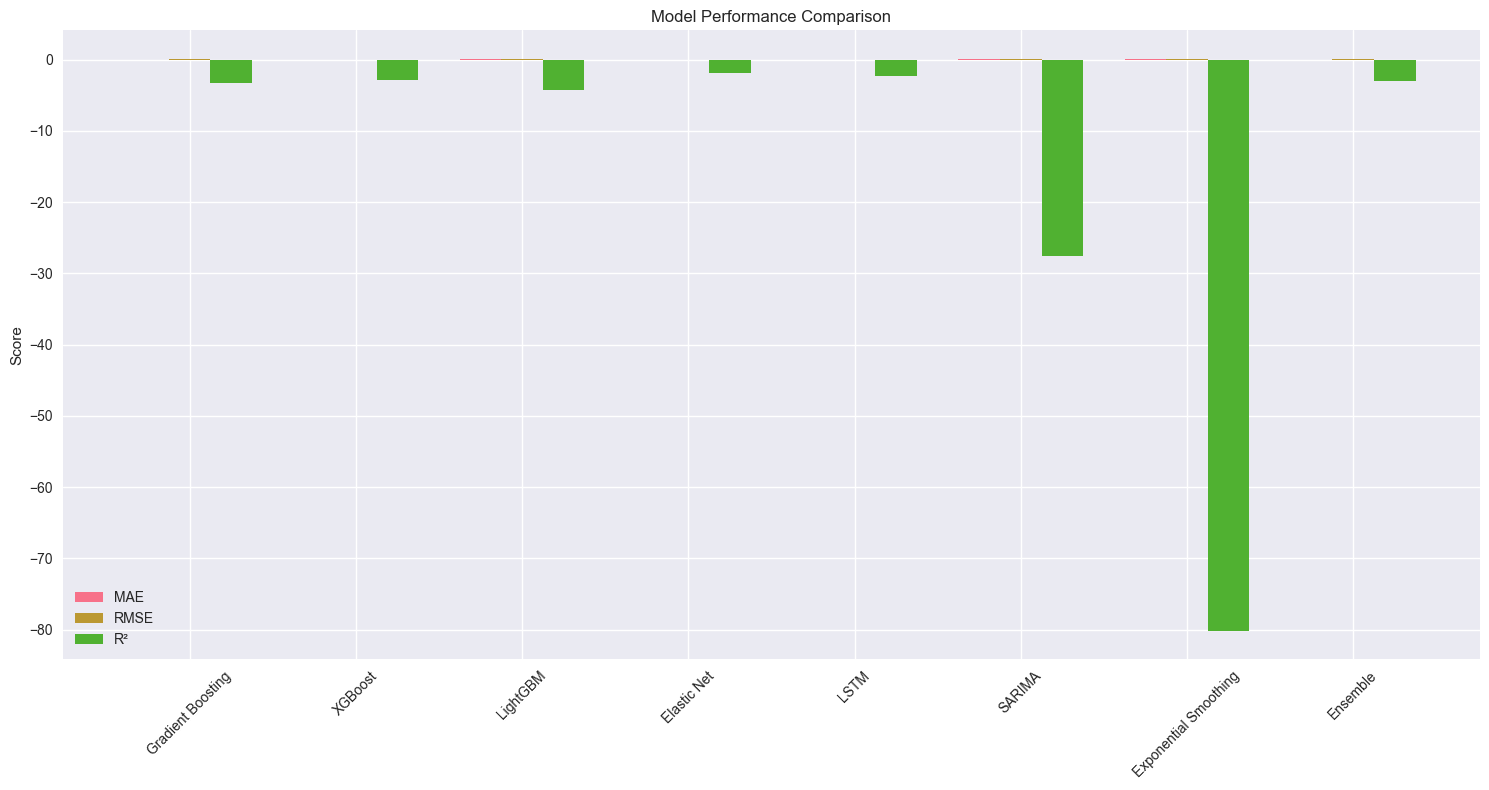

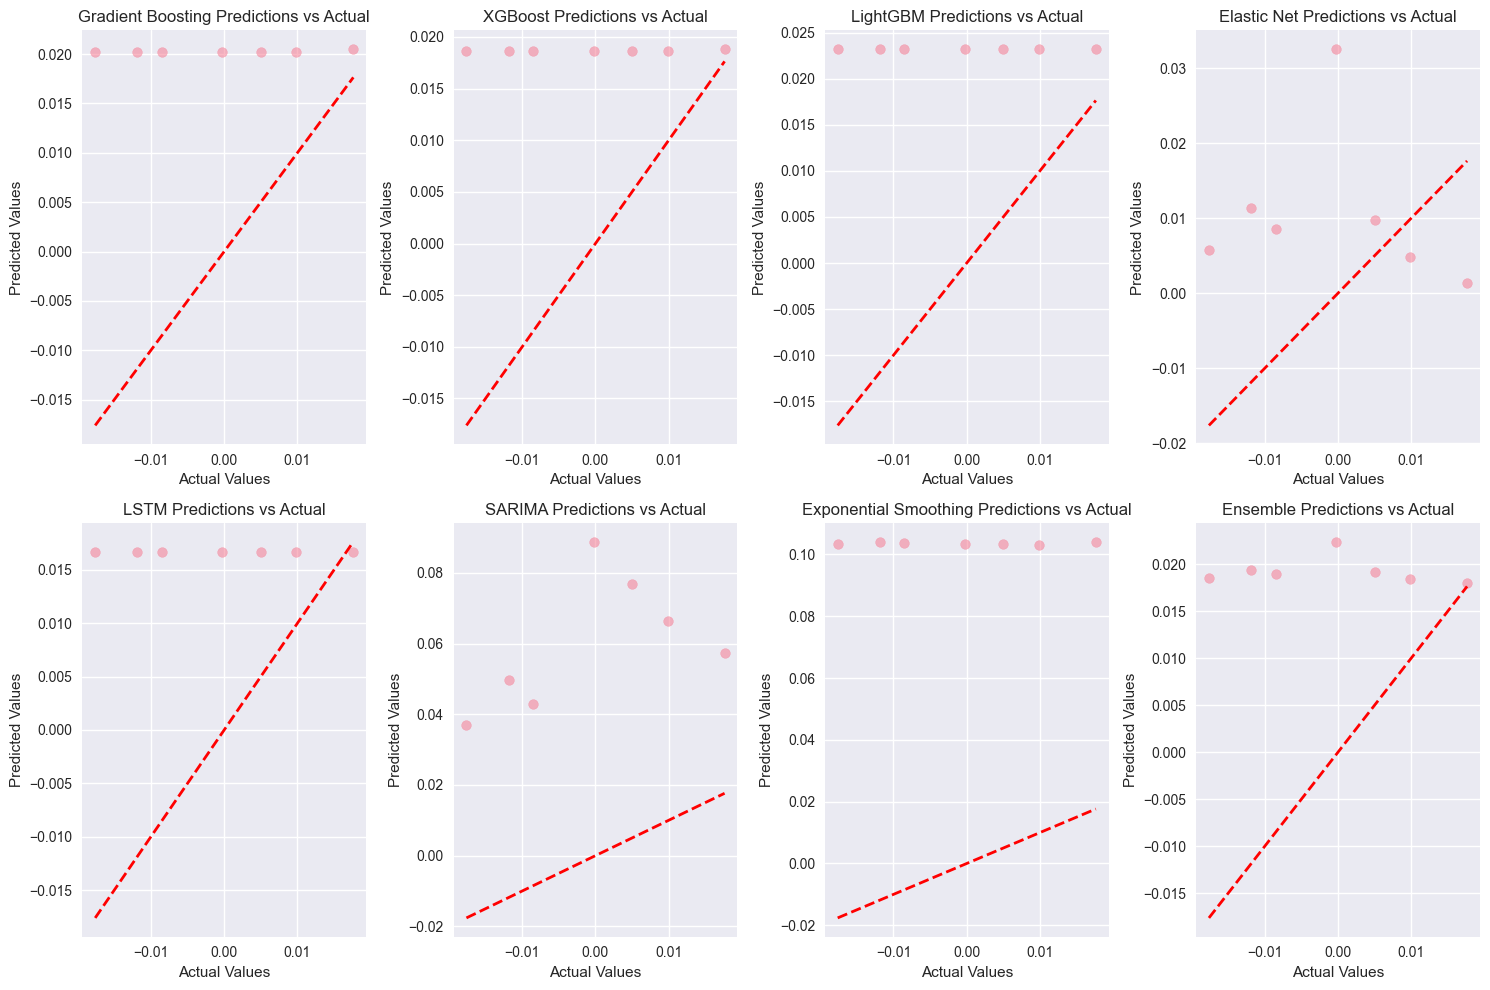

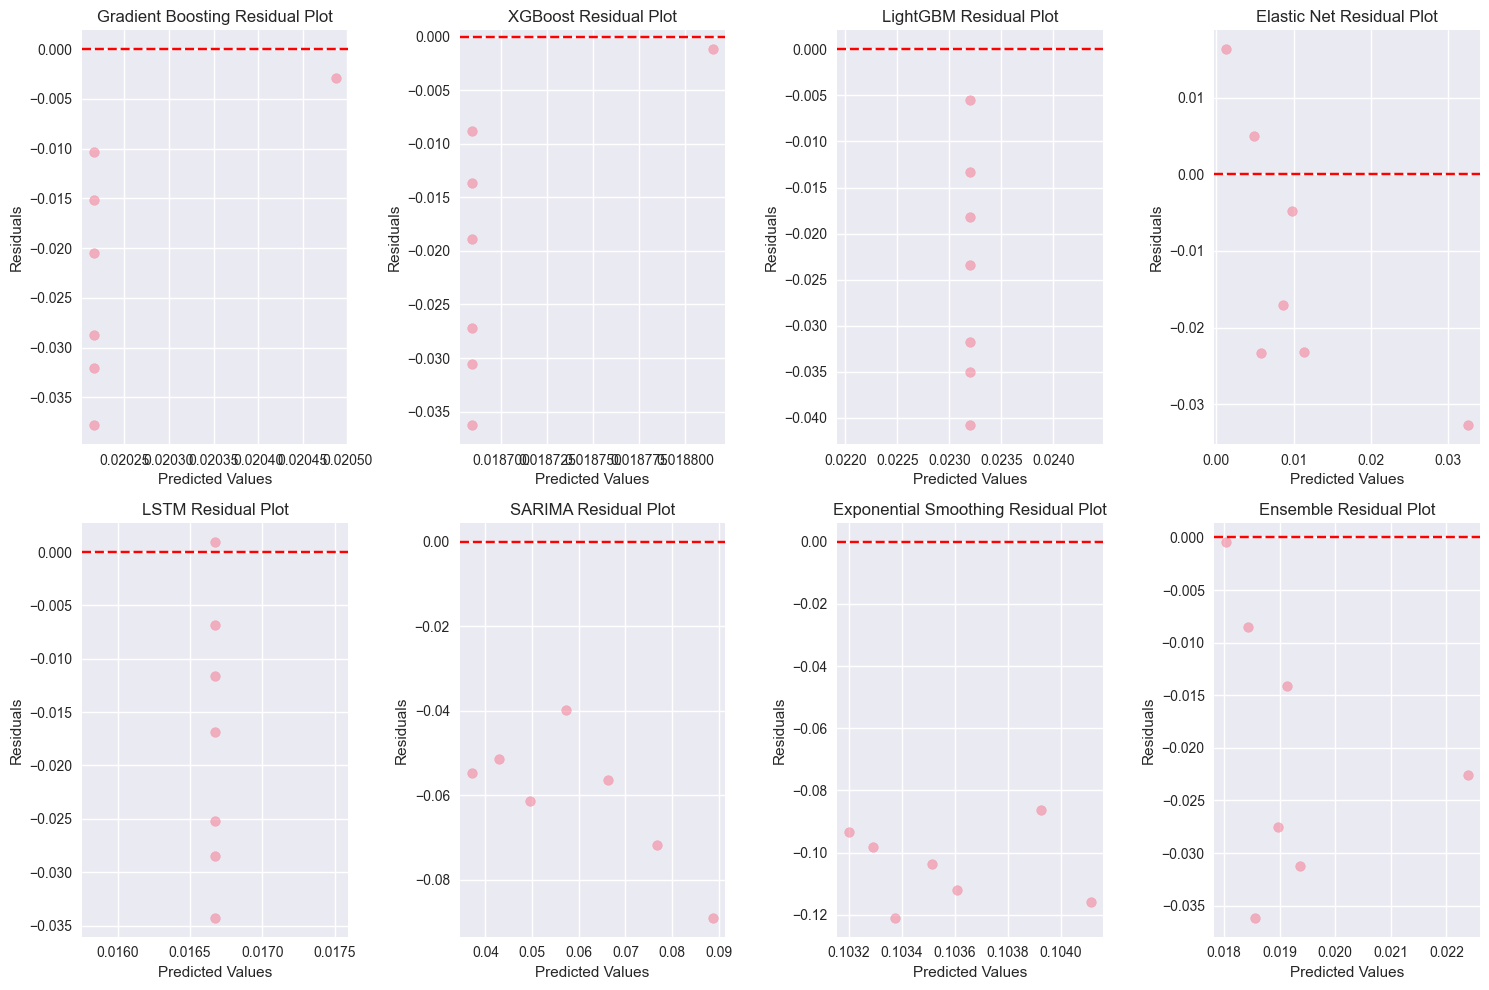

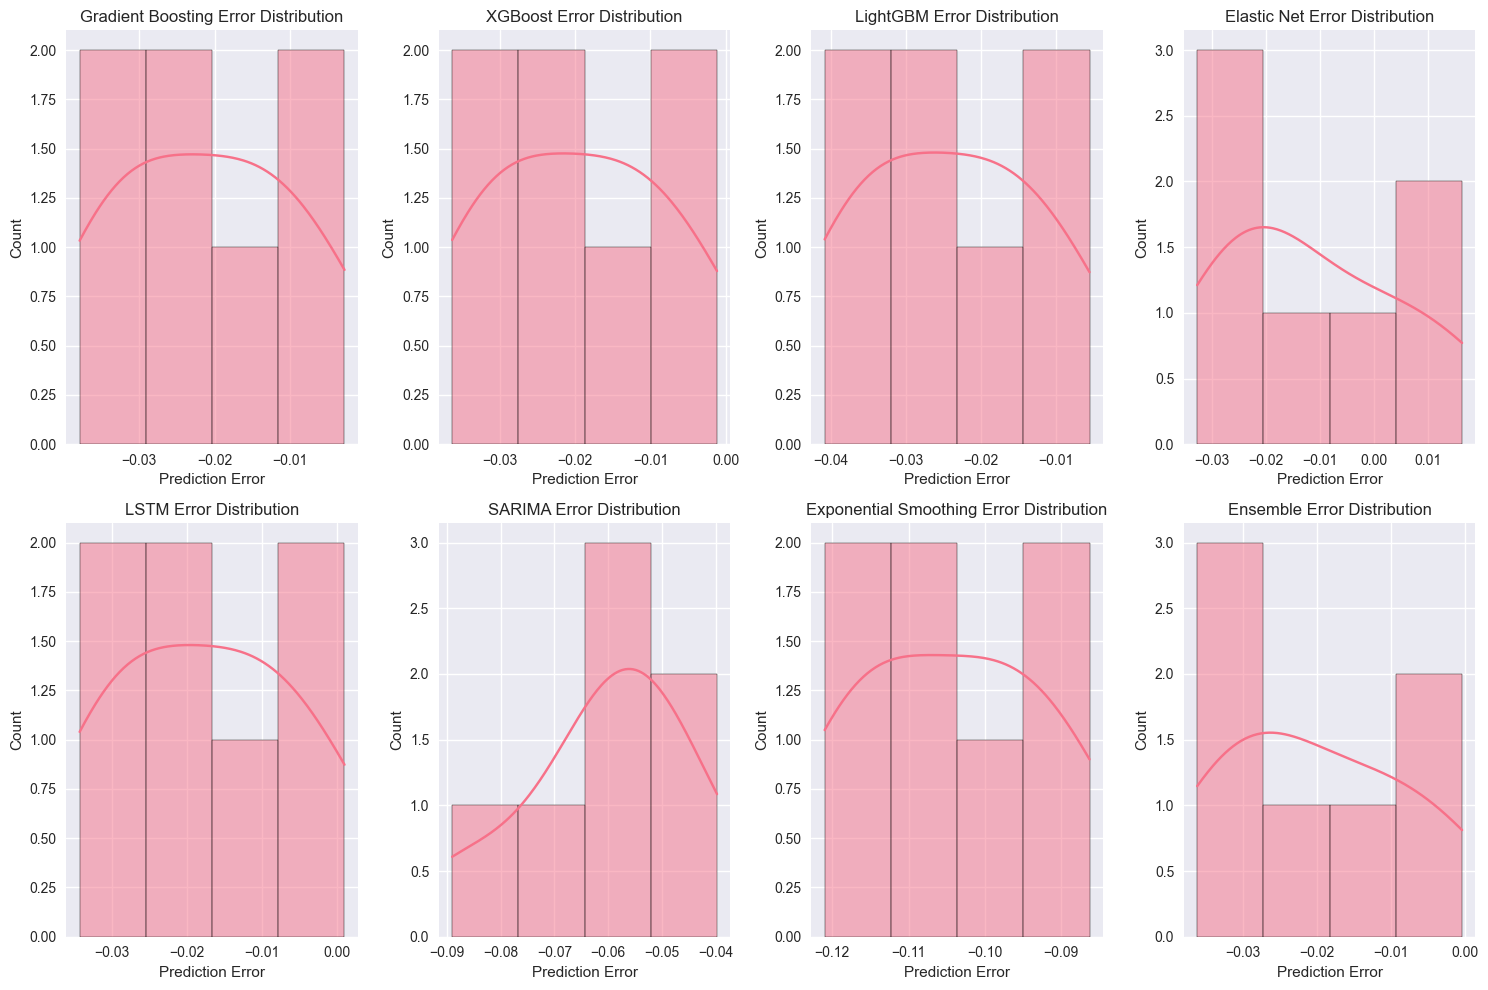

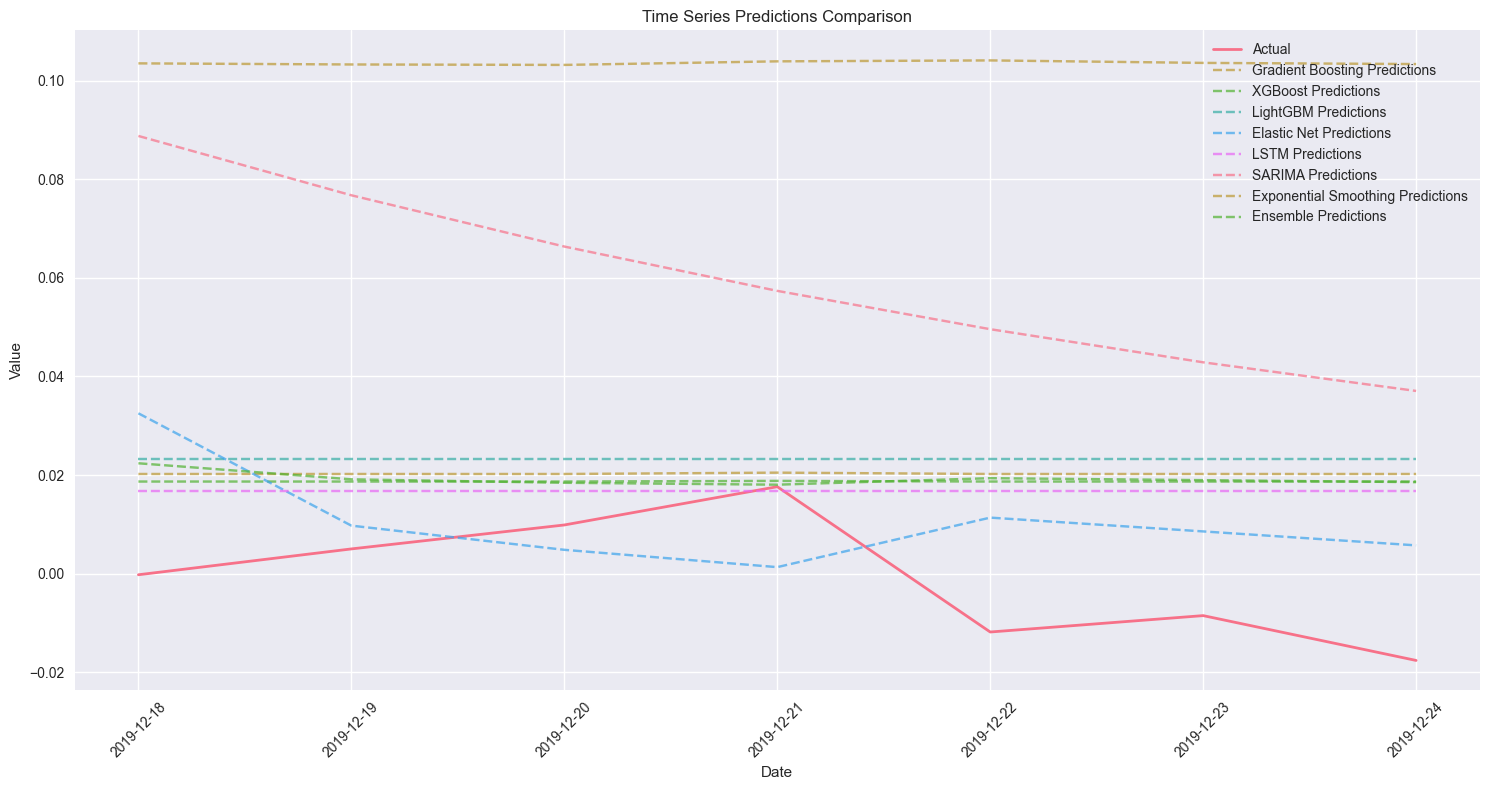

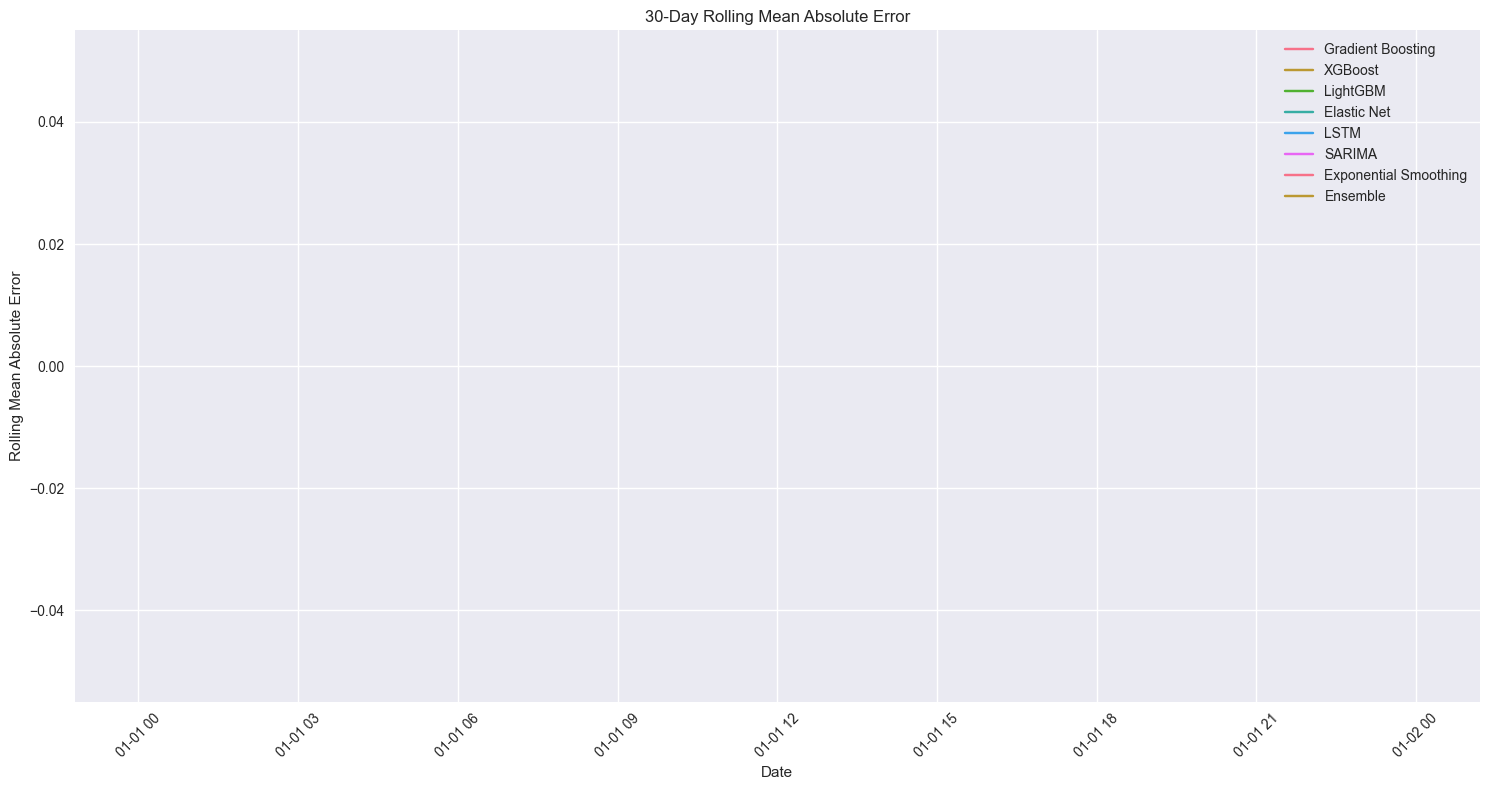

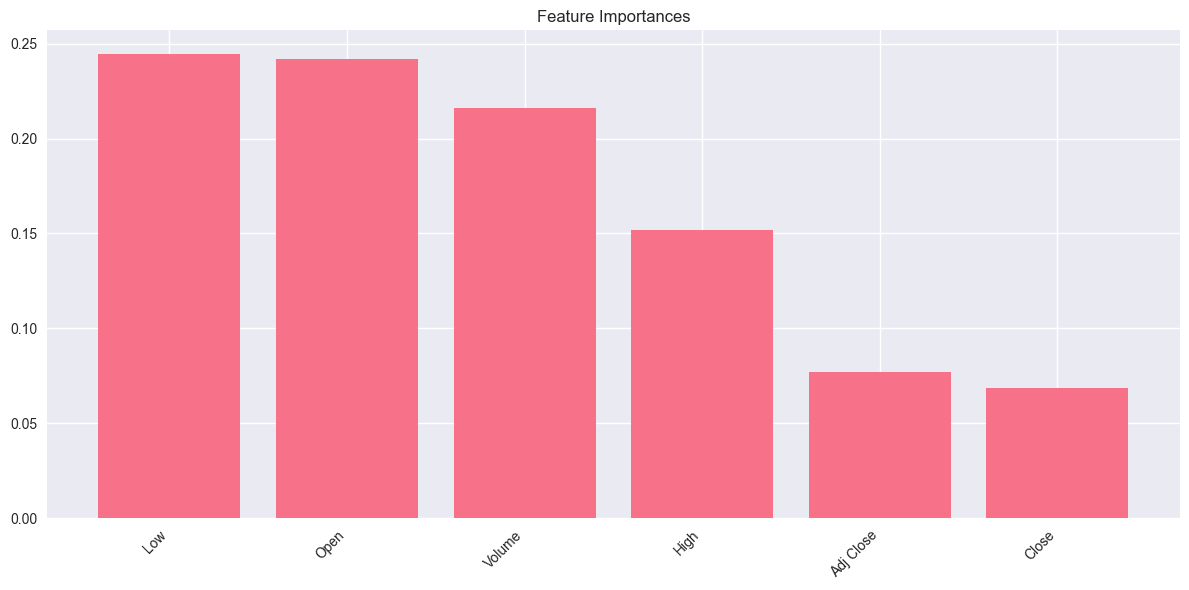

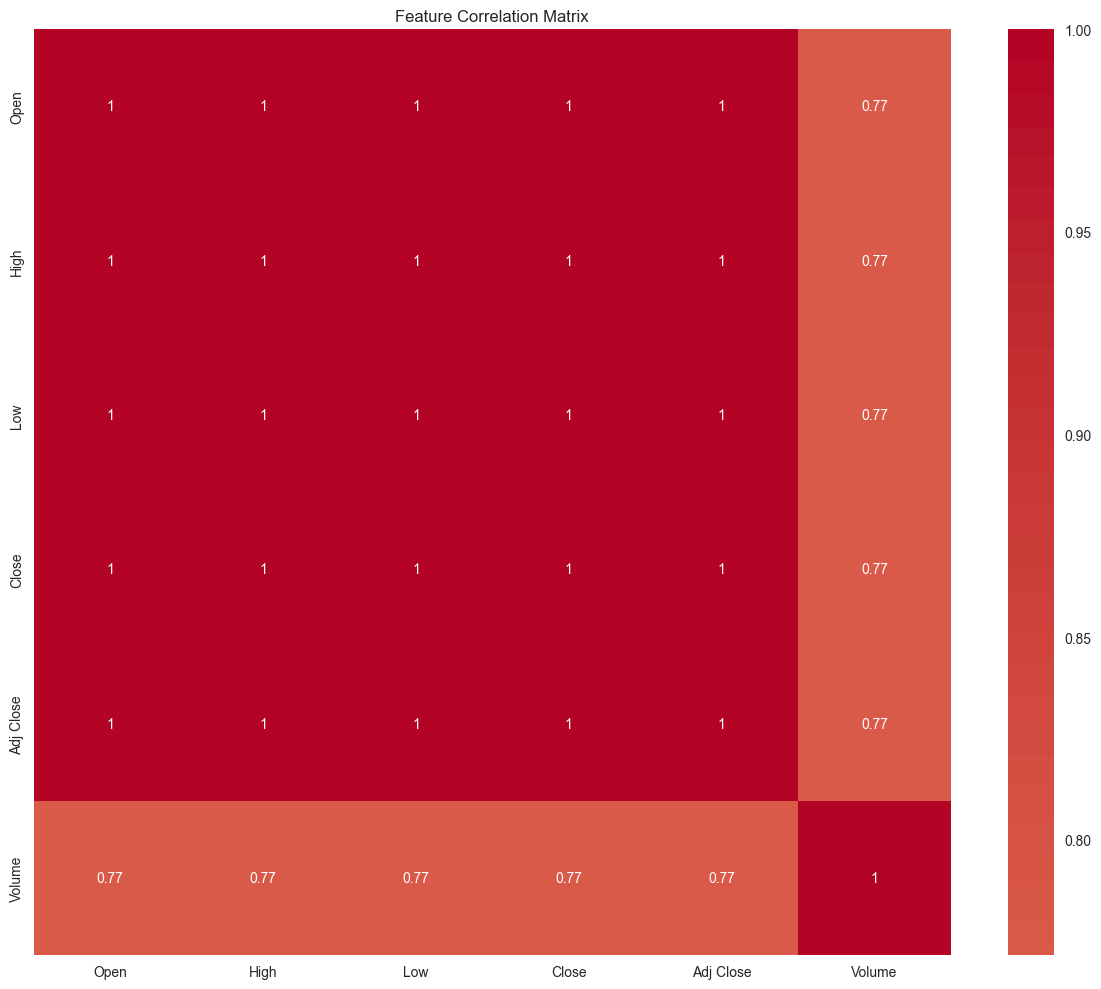

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd

# Set style for better visualization
plt.style.use('seaborn')
sns.set_palette("husl")

def create_model_comparison_plots(y_true, predictions_dict, model_names):
    """
    Create comparison plots for different models
    
    Parameters:
    -----------
    y_true : array-like
        True values
    predictions_dict : dict
        Dictionary containing predictions from different models
    model_names : list
        List of model names
    """
    
    # 1. Model Performance Comparison Bar Plot
    plt.figure(figsize=(12, 6))
    metrics = {
        'MAE': [mean_absolute_error(y_true, pred) for pred in predictions_dict.values()],
        'RMSE': [np.sqrt(mean_squared_error(y_true, pred)) for pred in predictions_dict.values()],
        'R2': [r2_score(y_true, pred) for pred in predictions_dict.values()]
    }
    
    x = np.arange(len(model_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.bar(x - width, metrics['MAE'], width, label='MAE')
    ax.bar(x, metrics['RMSE'], width, label='RMSE')
    ax.bar(x + width, metrics['R2'], width, label='R²')
    
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    # 2. Prediction vs Actual Scatter Plots
    fig = plt.figure(figsize=(15, 10))
    for idx, (model_name, predictions) in enumerate(predictions_dict.items(), 1):
        plt.subplot(2, (len(model_names)+1)//2, idx)
        plt.scatter(y_true, predictions, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} Predictions vs Actual')
    plt.tight_layout()
    plt.show()
    
    # 3. Residual Plots
    fig = plt.figure(figsize=(15, 10))
    for idx, (model_name, predictions) in enumerate(predictions_dict.items(), 1):
        residuals = y_true - predictions
        plt.subplot(2, (len(model_names)+1)//2, idx)
        plt.scatter(predictions, residuals, alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'{model_name} Residual Plot')
    plt.tight_layout()
    plt.show()
    
    # 4. Error Distribution
    fig = plt.figure(figsize=(15, 10))
    for idx, (model_name, predictions) in enumerate(predictions_dict.items(), 1):
        residuals = y_true - predictions
        plt.subplot(2, (len(model_names)+1)//2, idx)
        sns.histplot(residuals, kde=True)
        plt.xlabel('Prediction Error')
        plt.ylabel('Count')
        plt.title(f'{model_name} Error Distribution')
    plt.tight_layout()
    plt.show()

def create_time_series_plots(dates, y_true, predictions_dict, model_names):
    """
    Create time series plots for model predictions
    
    Parameters:
    -----------
    dates : array-like
        Dates for the time series
    y_true : array-like
        True values
    predictions_dict : dict
        Dictionary containing predictions from different models
    model_names : list
        List of model names
    """
    
    # 1. Time Series Plot
    plt.figure(figsize=(15, 8))
    plt.plot(dates, y_true, label='Actual', linewidth=2)
    for model_name, predictions in predictions_dict.items():
        plt.plot(dates, predictions, '--', label=f'{model_name} Predictions', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Time Series Predictions Comparison')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Rolling Mean Error
    plt.figure(figsize=(15, 8))
    window = 30  # 30-day rolling window
    for model_name, predictions in predictions_dict.items():
        error = np.abs(y_true - predictions)
        rolling_mean_error = pd.Series(error).rolling(window=window).mean()
        plt.plot(dates, rolling_mean_error, label=f'{model_name}')
    plt.xlabel('Date')
    plt.ylabel('Rolling Mean Absolute Error')
    plt.title(f'{window}-Day Rolling Mean Absolute Error')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def create_feature_importance_plot(model, feature_names):
    """
    Create feature importance plot for tree-based models
    
    Parameters:
    -----------
    model : object
        Trained model object (must have feature_importances_ attribute)
    feature_names : list
        List of feature names
    """
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 6))
        plt.title('Feature Importances')
        plt.bar(range(len(indices)), importances[indices])
        plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def plot_correlation_matrix(X, feature_names):
    """
    Create correlation matrix heatmap
    
    Parameters:
    -----------
    X : array-like
        Feature matrix
    feature_names : list
        List of feature names
    """
    
    corr_matrix = pd.DataFrame(X, columns=feature_names).corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Create dictionary of predictions
    predictions_dict = {
        'Gradient Boosting': gb_pred,
        'XGBoost': xgb_pred,
        'LightGBM': lgb_pred,
        'Elastic Net': elastic_net_pred,
        'LSTM': lstm_pred,
        'SARIMA': sarima_pred,
        'Exponential Smoothing': exp_smoothing_pred,
        'Ensemble': ensemble_pred
    }
    
    # Create model comparison plots
    create_model_comparison_plots(y_test, predictions_dict, list(predictions_dict.keys()))
    
    # Create time series plots
    create_time_series_plots(X_test.index, y_test, predictions_dict, list(predictions_dict.keys()))
    
    # Create feature importance plot for GB model
    create_feature_importance_plot(gb_best, X_train.columns)
    
    # Create correlation matrix plot
    plot_correlation_matrix(X_train, X_train.columns)